## Testing PCM regression 


In [ ]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
# Read in test data
f = open('/Users/jdiedrichsen/Python/PcmPy/demos/data_regression_test.p','rb')
Z,Y,U,comp = pickle.load(f)
f.close()

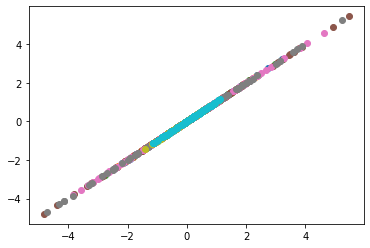

In [9]:
# Build the datasets from the Data and condition vectors 
M1 = pcm.regression.RidgeDiag(comp, fit_intercept = False)
M1.optimize_regularization(Z,Y)
M1.fit(Z,Y)
Y1 = M1.predict(Z)

M2 = Ridge(alpha=1,fit_intercept=False)
M2.fit(Z,Y)
Y2 = M2.predict(Z)

for i in range(10):
    plt.scatter(M1.coef_[i,:],M2.coef_[:,i])

In [23]:
# Check if it matches simulation 
def do_sim(): 
    num_sim = 10
    N = 50 
    Q = 10 
    P = 100 
    comp  = np.array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    theta = np.array([0, 1, -1, 3])
    s = sqrt(exp(theta[comp]))
    z = np.zeros((num_sim,))
    T = pd.DataFrame({'theta0':z,'theta1':z,'theta2':z,'theta3':z,'R2_Pcm':z,'R2_Lin':z,'R2_Rid':z})

    M = pcm.regression.RidgeDiag(comp, fit_intercept = False)
    R = Ridge(alpha=30.0, fit_intercept=False)
    # set the tolerance to a large value to make the example faster
    R_pipe = Pipeline(steps=[('ridge', R)])
    param_grid = {
        'ridge__alpha': exp(np.linspace(-1,5,10))
        }    
    L = LinearRegression(fit_intercept=False)

    for i in range(num_sim):
        # Make training data 
        U = np.random.normal(0,1,(Q,P))
        U = U * s.reshape((10,1)) 
        Z = np.random.normal(0,1,(N,Q))
        Y = Z @ U + np.random.normal(0,sqrt(exp(theta[-1])),(N,P))

        # Make test data 
        Zt = np.random.normal(0,1,(N,Q))
        Yt = Zt @ U + np.random.normal(0,1,(N,P))

        # PCM regression 
        M.optimize_regularization(Z,Y)
        M.fit(Z,Y)
        Yp = M.predict(Zt)
        T['theta0'][i]=M.theta_[0]
        T['theta1'][i]=M.theta_[1]
        T['theta2'][i]=M.theta_[2]
        T['theta3'][i]=M.theta_[3]
        T['R2_Pcm'][i]=1-np.sum((Yt-Yp)**2)/np.sum(Yt**2)
        
        # Linear regression 
        L.fit(Z,Y)
        Yp2 = L.predict(Zt)
        T['R2_Lin'][i]=1-np.sum((Yt-Yp2)**2)/np.sum(Yt**2)
        
        # Ridge regression
        R_search = GridSearchCV(R_pipe, param_grid, n_jobs=-1)
        R_search.fit(Z,Y)
        print(R_search.best_params_)
        R_pipe.set_params(R_search.best_params_)
        R_pipe.fit(Z,Y)
        Yp3 = R_pipe.predict(Zt)
        T['R2_Rid'][i]=1-np.sum((Yt-Yp3)**2)/np.sum(Yt**2)
    return T

In [25]:
D = do_sim()

{'ridge__alpha': 10.312258501325761}


TypeError: set_params() takes 1 positional argument but 2 were given

In [ ]:
exp(np.linspace(-1,5,10))

In [ ]:
# Fit the model in to the full group, using a individual scaling parameter for each 
T_gr, theta = pcm.inference.fit_model_group(Y, M, fit_scale=True)


In [ ]:
# crossvalidated likelihood is the same as the group fit for all 
# except the component and noise ceiling model
T_cv, theta_cv = pcm.inference.fit_model_group_crossval(Y, M, fit_scale=True)


In [ ]:
ax = pcm.vis.model_plot(T_cv.likelihood,null_model = 'null',noise_ceiling= 'ceil',upper_ceiling = T_gr.likelihood['ceil'])


In [ ]:
T_gr

In [ ]:
G,_ = M[4].predict(theta[4][:M[4].n_param])
plt.imshow(G)